# Textile Defect Detection CNN


## 1. Environment Setup

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import os
from pathlib import Path

### Check CUDA availability


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA version: 11.8


## 2. Data Preparation

In [7]:
PROJECT_ROOT = Path.cwd().parent  # Goes up from notebooks/ to project root
print(f"Project root: {PROJECT_ROOT}")

# Set up paths relative to project root
DATA_ROOT = PROJECT_ROOT / "data"
TRAIN_DIR = DATA_ROOT / "augmented_train"
TEST_DIR = DATA_ROOT / "split" / "test"

BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)  # Adjusted for textile defect detection

Project root: c:\Users\Marcony1\OneDrive - Fundacion Universidad de las Americas Puebla\Documents\Git\textile-image-defect-detector


In [8]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Create datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

In [10]:
# Class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['NO_OK', 'OK']


In [11]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [12]:
# Show batch
def show_batch(images, labels):
    plt.figure(figsize=(12, 8))
    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

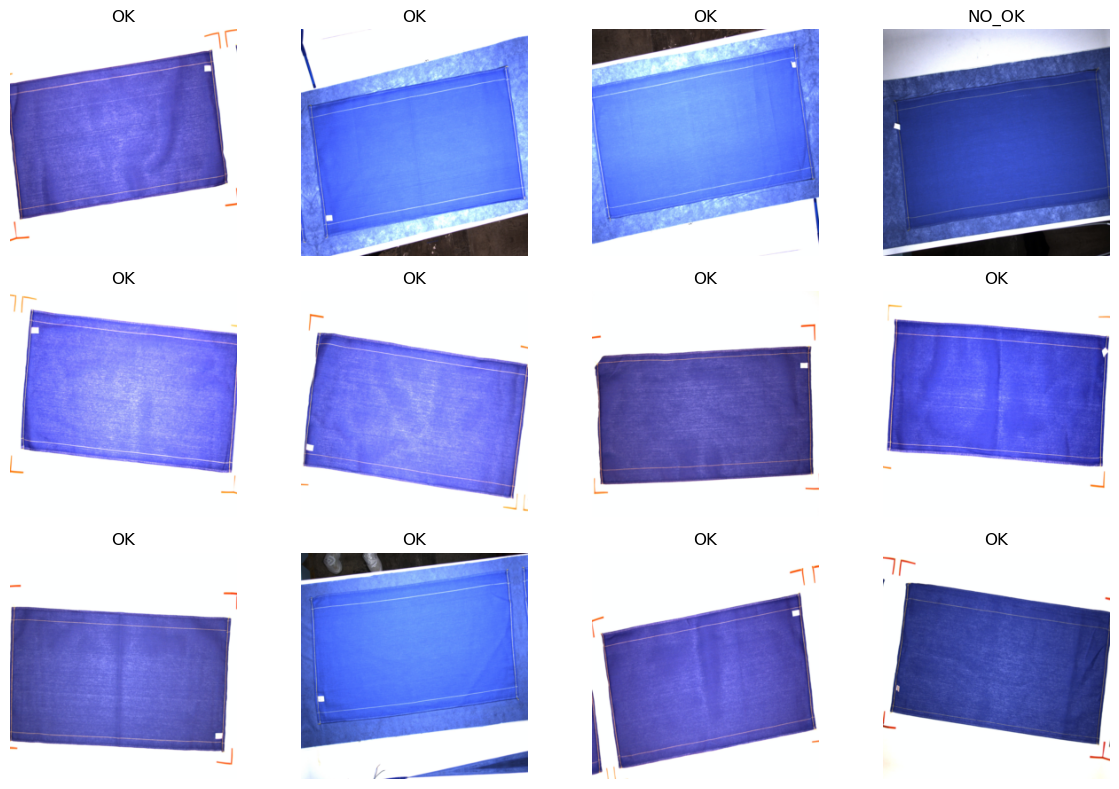

In [13]:
# Display sample
images, labels = next(iter(train_loader))
show_batch(images, labels)

## 3. CNN Model Definition


In [14]:
class TextileDefectCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(TextileDefectCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [15]:
model = TextileDefectCNN(num_classes=2).to(device)

In [16]:
# Print summary
print(model)

TextileDefectCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)

## 4. Training Setup


In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [ ]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects.double() / len(test_dataset)
        
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)
        
        scheduler.step(epoch_loss)
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print()
        
        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), '../models/best_model_baseline.pt')
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

## 5. Model Training


In [19]:
# Train the model
model, train_loss, train_acc, val_loss, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs=20
)

Epoch 1/20
----------
Train Loss: 0.6745 Acc: 0.7380
Val Loss: 0.5828 Acc: 0.7391

Epoch 2/20
----------
Train Loss: 0.5874 Acc: 0.7380
Val Loss: 0.5926 Acc: 0.7391

Epoch 3/20
----------
Train Loss: 0.5740 Acc: 0.7380
Val Loss: 0.5643 Acc: 0.7391

Epoch 4/20
----------
Train Loss: 0.5710 Acc: 0.7380
Val Loss: 0.5541 Acc: 0.7391

Epoch 5/20
----------
Train Loss: 0.5615 Acc: 0.7343
Val Loss: 0.5597 Acc: 0.7391

Epoch 6/20
----------
Train Loss: 0.5565 Acc: 0.7380
Val Loss: 0.5493 Acc: 0.7391

Epoch 7/20
----------
Train Loss: 0.5263 Acc: 0.7429
Val Loss: 0.5759 Acc: 0.7681

Epoch 8/20
----------
Train Loss: 0.5044 Acc: 0.7651
Val Loss: 0.5126 Acc: 0.7826

Epoch 9/20
----------
Train Loss: 0.4589 Acc: 0.7909
Val Loss: 0.5122 Acc: 0.7391

Epoch 10/20
----------
Train Loss: 0.4561 Acc: 0.7946
Val Loss: 0.5365 Acc: 0.7681

Epoch 11/20
----------
Train Loss: 0.4381 Acc: 0.8007
Val Loss: 0.4935 Acc: 0.7681

Epoch 12/20
----------
Train Loss: 0.4218 Acc: 0.8069
Val Loss: 0.5401 Acc: 0.6957

E

## 6. Training Visualization


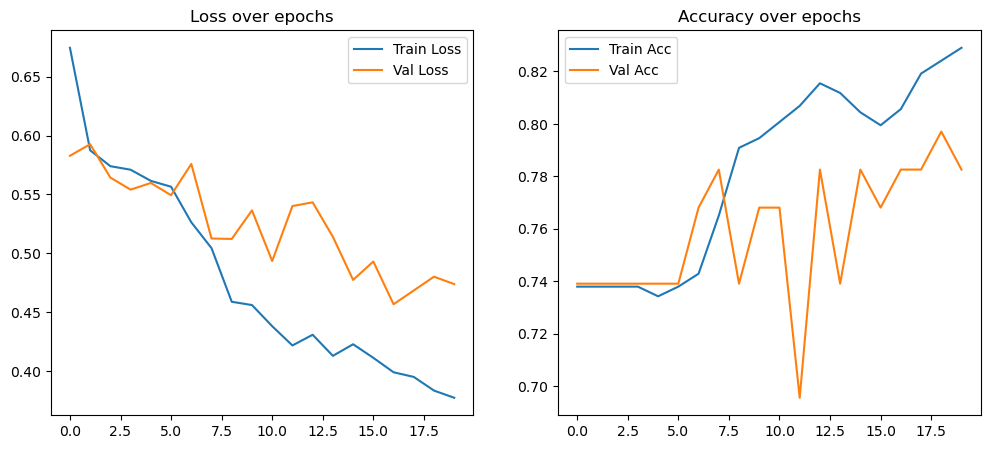

In [20]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([x.cpu().numpy() for x in train_acc], label='Train Acc')
plt.plot([x.cpu().numpy() for x in val_acc], label='Val Acc')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

## 7. Model Evaluation


In [ ]:
# Load best model
model.load_state_dict(torch.load('../models/best_model_baseline.pt'))
model.eval()

TextileDefectCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)

In [22]:
# Test evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [23]:
# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

       NO_OK       1.00      0.22      0.36        18
          OK       0.78      1.00      0.88        51

    accuracy                           0.80        69
   macro avg       0.89      0.61      0.62        69
weighted avg       0.84      0.80      0.74        69



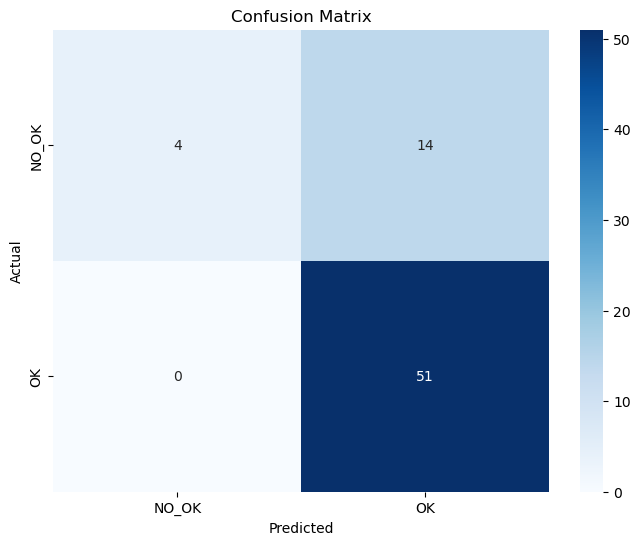

In [25]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 8. Save Final Model

In [27]:
# Save the entire model
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'image_size': IMAGE_SIZE
}, '../models/textile_defect_model_baseline.pt')

print("Model saved successfully!")

Model saved successfully!
